In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
from pathlib import Path
import numpy as np
#import pandas_datareader as pdr
import hvplot.pandas
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt


import scipy.optimize as sco
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#Read data files

quandl_file = Path("Resources/Quandl_data.csv")
asset_file = Path("Resources/asset_prices.csv")
bitcoin_file = Path("Resources/bitcoin_data.csv")

alt_data_df = pd.read_csv(quandl_file, index_col = "yr_mo", infer_datetime_format = True, parse_dates = True)
asset_prices_df = pd.read_csv(asset_file, index_col = "Date", infer_datetime_format = True, parse_dates = True)
bitcoin_df = pd.read_csv(bitcoin_file, index_col = "Date" , infer_datetime_format = True, parse_dates = True)

bitcoin_df.drop(columns = ["Open*", "High", "Low", "Volume", "Market Cap"], inplace=True)
bitcoin_df.columns = ["Bitcoin"]
bitcoin_df.sort_index()

asset_prices_df.drop(columns = "BLOK", inplace= True)
asset_prices_df = pd.merge(asset_prices_df, bitcoin_df, how = "inner", on= "Date" )
asset_prices_df.sort_index(inplace=True)
asset_prices_df["Bitcoin"]= asset_prices_df["Bitcoin"].str.replace(",", "").astype(float)

In [3]:
alt_data_df.head()

SP500_ia_price  SP500_pe  SP500_pe_shiller  SP500_eyield  \
yr_mo                                                                  
2005-01-01         1588.39     19.99             26.59          5.00   
2005-04-01         1534.19     19.02             25.41          5.26   
2005-07-01         1603.76     19.00             26.29          5.26   
2005-10-01         1534.19     17.64             24.88          5.67   
2006-01-01         1653.35     18.07             26.47          5.53   

            30y_mort_int  15y_mort_int  Unemployment_ST  Unemployment_LT  \
yr_mo                                                                      
2005-01-01         5.710        5.1725         5.020076         5.020076   
2005-04-01         5.855        5.4075         5.011637         5.011637   
2005-07-01         5.695        5.2775         5.003654         5.003654   
2005-10-01         6.065        5.6250         4.996717         4.996717   
2006-01-01         6.145        5.7100         4.990856         4.990856   

            PPI_pp  CPI_urban        GDP_R        GDP_N  
yr_mo                                                    
2005-01-01    94.8      111.3  14810.87545  12795.23037  
2005-04-01    90.4      113.4  14908.47011  12969.74010  
2005-07-01    83.8      113.7  15003.90414  13170.81850  
2005-10-01    79.5      115.7  15096.59206  13358.83971  
2006-01-01    76.0      115.2  15185.73548  13531.48797

In [4]:
asset_prices_df.dropna(inplace=True)
asset_prices_df.tail()

BIZD   DBO         GLD         IWM        SHY         SPY  \
Date                                                                         
2020-06-23  11.735950  7.13  166.479996  143.000000  86.499031  312.049988   
2020-06-24  11.435774  6.82  165.899994  138.360001  86.509033  304.089996   
2020-06-25  11.590704  6.99  165.800003  140.449997  86.509033  307.350006   
2020-06-26  11.464823  6.84  166.539993  136.669998  86.539009  300.049988   
2020-06-29  11.619753  7.03  166.630005  141.139999  86.558998  304.459991   

                  STIP       USRT        UUP        VGLT        VWO  Bitcoin  
Date                                                                          
2020-06-23  102.419998  43.630001  26.150000   98.456184  40.470001  9629.66  
2020-06-24  102.269997  42.500000  26.270000   99.444740  39.860001  9313.61  
2020-06-25  102.239998  43.090000  26.309999   99.674408  40.029999  9264.81  
2020-06-26  102.220001  42.310001  26.350000  100.722878  39.549999  9162.92  
2020-06-29  102.349998  43.139999  26.360001  100.423317  39.810001  9190.85

In [5]:
asset_returns_monthly_df = asset_prices_df[asset_prices_df.index.day == 1].pct_change()
asset_returns_monthly_df.dropna(inplace=True)
asset_returns_monthly_df.head()

BIZD       DBO       GLD       IWM       SHY       SPY  \
Date                                                                     
2013-07-01 -0.005892  0.037713 -0.141592  0.073623 -0.002083  0.024854   
2013-08-01  0.033367  0.052028  0.045241  0.070504  0.000806  0.057635   
2013-10-01  0.009359 -0.005455 -0.015955  0.029191  0.001376 -0.002898   
2013-11-01  0.005911 -0.021207  0.018942  0.008067  0.000580  0.040569   
2014-04-01  0.031400  0.047815 -0.028043  0.091146  0.000260  0.078868   

                STIP      USRT       UUP      VGLT       VWO   Bitcoin  
Date                                                                    
2013-07-01 -0.016877 -0.092557  0.014878 -0.099622 -0.090380 -0.247372  
2013-08-01  0.006256  0.005954 -0.010218 -0.035859  0.023675  0.181147  
2013-10-01 -0.001579 -0.017652 -0.030072  0.012987  0.037476  0.270962  
2013-11-01  0.001186  0.022537  0.006478  0.002326  0.022477  0.559843  
2014-04-01 -0.001679  0.034810 -0.013333  0.028251 -0.013087  1.320206

In [6]:
asset_returns_df = asset_prices_df.pct_change().dropna()
asset_returns_df.head()

BIZD       DBO       GLD       IWM       SHY       SPY  \
Date                                                                     
2013-04-30  0.003868 -0.012629  0.003303  0.005664 -0.000119  0.002385   
2013-05-01 -0.029384 -0.023643 -0.011627 -0.024230  0.000202 -0.008768   
2013-05-02  0.012407  0.034934  0.005740  0.015901 -0.000119  0.009288   
2013-05-03  0.008824  0.014960  0.001198  0.015867 -0.000355  0.010141   
2013-05-06 -0.002430  0.004913  0.000422  0.006437  0.000000  0.002541   

                STIP      USRT       UUP      VGLT       VWO   Bitcoin  
Date                                                                    
2013-04-30 -0.001360  0.011894 -0.004930 -0.002775  0.012494 -0.038328  
2013-05-01 -0.001470 -0.005545 -0.000901  0.009186 -0.010512 -0.158345  
2013-05-02  0.000390  0.003791  0.006763 -0.000780  0.009238 -0.100692  
2013-05-03  0.000683 -0.002666 -0.000448 -0.021210  0.006865 -0.070906  
2013-05-06  0.000682  0.004678  0.002240 -0.001994  0.001136  0.148849

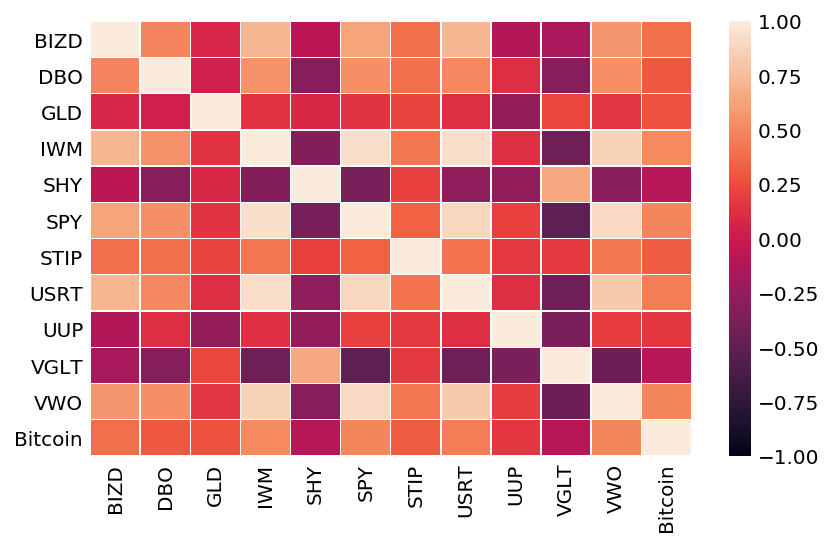

In [7]:
#asset correlation for 2020
corr_assets = asset_returns_df[asset_returns_df.index > '2020-01-01'].corr()
sns.heatmap(corr_assets,vmin=-1, vmax=1, linewidths = .2)

In [8]:
#summer correlation coefficients

corr_assets.sum().sort_values(axis=0,ascending=True)

VGLT      -0.734086
SHY       -0.110024
UUP        1.080278
GLD        2.251221
DBO        3.817395
Bitcoin    4.219649
STIP       4.489806
BIZD       4.662251
SPY        5.177882
VWO        5.206598
USRT       5.267298
IWM        5.448040
dtype: float64

In [9]:
# standard deviation
assets_st_dev_19 = asset_returns_df[(asset_returns_df.index >= '2019-01-01') & (asset_returns_df.index < '2020-01-01') ].std()
assets_st_dev_19 = pd.DataFrame(assets_st_dev_19, columns = ['STD_19'] )

assets_st_dev_20 = asset_returns_df[asset_returns_df.index >= '2020-01-01'].std()
assets_st_dev_20 = pd.DataFrame(assets_st_dev_20, columns = ['STD_20'] )

#assets_st_dev_19

In [10]:
# annualized standard deviation
annualized_st_dev = asset_returns_df.std() * np.sqrt(252)
annualized_st_dev = pd.DataFrame(annualized_st_dev, columns = ['Annualized_STD'] )
#annualized_st_dev

In [11]:
#sharpe ratios

sharpe_ratios_df = (asset_returns_df.mean() * 252) / (asset_returns_df.std() * np.sqrt(252))
sharpe_ratios_df = pd.DataFrame( sharpe_ratios_df, columns = ['Sharpe_Ratios'] )
#sharpe_ratios_df


In [12]:
#Average return over the whole period #CHANGE TO ANNUAL FOR 2019 and YTD for 2020

mean_daily_return_df_19 = pd.DataFrame(asset_returns_df[(asset_returns_df.index>='2019-01-01') & 
                                                        (asset_returns_df.index<'2020-01-01')].mean(),
                                                         columns = ['Avg_daily_return_2019'])

mean_daily_return_df_20 = pd.DataFrame(asset_returns_df[(asset_returns_df.index>='2020-01-01')].mean(),
                                                         columns = ['Avg_daily_return_2020'])


# Annual 2019 and YTD 2020 returns


annual_return_df_19 = pd.DataFrame()
ytd_return_df_20 = pd.DataFrame()


for ticker in asset_prices_df.columns:
    annual_return_df_19.set_value(ticker, "Annual_return_19", (asset_prices_df.loc["2019-12-27", ticker] / asset_prices_df.loc["2019-01-02", ticker]) -1)
    ytd_return_df_20.set_value(ticker,"YTD_return_20",  (asset_prices_df.loc["2020-06-29", ticker] / asset_prices_df.loc["2020-01-02", ticker]) -1)
    

returns_df = pd.merge(annual_return_df_19, ytd_return_df_20,  how ="inner", left_index = True, right_index=True)
returns_df


/Users/vanyaboranova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/vanyaboranova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Annual_return_19  YTD_return_20
BIZD             0.270929      -0.256050
DBO              0.268563      -0.342376
GLD              0.173082       0.157555
IWM              0.248250      -0.142449
SHY              0.033439       0.029093
SPY              0.314948      -0.053166
STIP             0.048353       0.019919
USRT             0.277678      -0.180023
UUP              0.037922       0.011512
VGLT             0.148603       0.206959
VWO              0.205923      -0.120242
Bitcoin          0.848677       0.315710

In [13]:
#BETA FUNCTION

def calculate_beta(data, market_variable = "SPY"):
    
    beta_df = pd.DataFrame(index=[1])
    
    for i in data.columns:
        
        variance = data[i].var()
        covariance = data[i].cov(data[market_variable])
        beta = covariance / variance

        beta_df[i]= beta
    
    return beta_df.T



In [14]:
#beta represents the volatility compared to the market, beta more then 1 means the asset is more riskier

beta_df_19 = calculate_beta(asset_returns_df[(asset_returns_df.index>='2019-01-01') & 
                                            (asset_returns_df.index<'2020-01-01')], "SPY")
beta_df_19.columns = ['Beta_19']

beta_df_20 = calculate_beta(asset_returns_df[(asset_returns_df.index>='2020-01-01')], "SPY")
beta_df_20.columns = ['Beta_20']
#beta_df

In [15]:
asset_returns_monthly_df[asset_returns_monthly_df.index>'2019-01-01'].hvplot(title = "Asset Returns 2019-2020")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [16]:
all_data = pd.merge(asset_returns_monthly_df, alt_data_df, how="inner",left_index = True, right_index=True)
all_data.dropna(inplace = True)
all_data.drop(columns = ["SP500_pe_shiller", "SP500_eyield", "15y_mort_int", 'SP500_pe','Unemployment_LT','GDP_R'], inplace=True)
all_data

BIZD       DBO       GLD       IWM       SHY       SPY  \
2013-07-01 -0.005892  0.037713 -0.141592  0.073623 -0.002083  0.024854   
2013-10-01  0.009359 -0.005455 -0.015955  0.029191  0.001376 -0.002898   
2014-04-01  0.031400  0.047815 -0.028043  0.091146  0.000260  0.078868   
2014-07-01  0.066683  0.086189  0.031502  0.072181  0.000568  0.051209   
2014-10-01 -0.024365 -0.066041 -0.061183 -0.023345  0.000923  0.014330   
2015-04-01 -0.003649 -0.333333 -0.008406  0.090492  0.003356  0.009713   
2015-07-01 -0.022574 -0.036006 -0.017719  0.007644  0.000094 -0.014467   
2015-10-01 -0.033329 -0.024306 -0.022619 -0.023031  0.002595  0.007086   
2016-04-01  0.094670  0.012179 -0.007133  0.062071  0.002134  0.049857   
2016-07-01  0.035662  0.024123  0.107556 -0.003369  0.007080  0.003527   
2018-10-01 -0.002426  0.159299 -0.022321  0.006101  0.001658  0.043405   
2019-04-01  0.012523  0.052217 -0.002872 -0.019385  0.005911  0.023782   
2019-07-01  0.010085 -0.062271  0.084884 -0.000891  0.012107  0.018121   
2019-10-01  0.017247 -0.022988  0.023605 -0.034989  0.004738 -0.000834   
2020-04-01 -0.466875 -0.396454  0.048331 -0.320271  0.029609 -0.187252   

                STIP      USRT       UUP      VGLT       VWO   Bitcoin  \
2013-07-01 -0.016877 -0.092557  0.014878 -0.099622 -0.090380 -0.247372   
2013-10-01 -0.001579 -0.017652 -0.030072  0.012987  0.037476  0.270962   
2014-04-01 -0.001679  0.034810 -0.013333  0.028251 -0.013087  1.320206   
2014-07-01  0.009109  0.033943  0.000000  0.009126  0.072568  0.399882   
2014-10-01 -0.010353 -0.029455  0.052510  0.033064 -0.060064 -0.355191   
2015-04-01 -0.006184  0.046975  0.109161  0.090590  0.006634 -0.347985   
2015-07-01  0.000000 -0.045406 -0.014838 -0.038672 -0.024840  0.160095   
2015-10-01  0.000906  0.047356  0.007226  0.017749  0.014046  0.041338   
2016-04-01  0.009536  0.078754 -0.038039  0.018211  0.090714 -0.039437   
2016-07-01  0.011142  0.074286  0.002429  0.074725  0.057919  0.259592   
2018-10-01  0.003430 -0.010864  0.011595 -0.014854 -0.045341 -0.135777   
2019-04-01  0.007891  0.039966  0.010490  0.048232  0.037310  0.077366   
2019-07-01  0.012605  0.008923 -0.001527  0.071263  0.006192  0.958859   
2019-10-01  0.002620  0.054906  0.013508  0.061265 -0.012574 -0.197736   
2020-04-01  0.000905 -0.339800  0.036138  0.191059 -0.227506 -0.286610   

            SP500_ia_price  30y_mort_int  Unemployment_ST  PPI_pp  CPI_urban  \
2013-07-01         1831.54      4.370000         5.202233    21.6    133.919   
2013-10-01         1888.30      4.192000         5.084251    21.3    133.876   
2014-04-01         2016.20      4.337500         4.883757    20.8    135.771   
2014-07-01         2123.36      4.128333         4.811866    20.6    136.392   
2014-10-01         2091.98      4.036000         4.760038    20.3    135.891   
2015-04-01         2270.13      3.672000         4.698205    19.9    135.222   
2015-07-01         2249.80      4.046000         4.669041    19.7    136.371   
2015-10-01         2182.78      3.796000         4.641627    19.5    135.735   
2016-04-01         2224.17      3.605000         4.593884    19.1    136.332   
2016-07-01         2289.70      3.440000         4.574120    18.9    137.007   
2018-10-01         2824.11      4.830000         4.474808    17.4    142.700   
2019-04-01         2913.41      4.142500         4.459941    16.4    143.926   
2019-07-01         2994.05      3.765000         4.452636    15.9    144.462   
2019-10-01         2966.66      3.688000         4.445388    15.4    144.851   
2020-04-01         2837.23      3.306000         4.431095    15.1    143.976   

                  GDP_N  
2013-07-01  17400.82260  
2013-10-01  17577.62405  
2014-04-01  17900.23707  
2014-07-01  18055.29178  
2014-10-01  18163.02728  
2015-04-01  18419.17969  
2015-07-01  18564.57978  
2015-10-01  18643.55000  
2016-04-01  18908.03000  
2016-07-01  19054.73000  
2018-10-01  20817.17000  
2019-04-01  21207.07000  
2019-07-01  21407.04000  
2

In [17]:
correlation = all_data[all_data.index>='2019-01-01'].corr()
#sns.heatmap(correlation,vmin=-1, vmax=1, linewidths = .2)

In [18]:
correlation.sum().sort_values(axis=0,ascending=True)

UUP               -7.362591
VGLT              -6.627724
GDP_N             -6.453109
SHY               -5.937717
GLD                0.887645
CPI_urban          3.050193
PPI_pp             5.351380
30y_mort_int       5.522987
Bitcoin            5.660331
STIP               6.323444
DBO                6.390241
Unemployment_ST    6.405946
USRT               6.635904
SP500_ia_price     6.746588
VWO                6.888932
BIZD               6.902073
SPY                7.039435
IWM                7.132130
dtype: float64

In [19]:
def get_rsi_timeseries(prices, n=14):
    # RSI = 100 - (100 / (1 + RS))
    # where RS = (Wilder-smoothed n-period average of gains / Wilder-smoothed n-period average of -losses)
    # Note that losses above should be positive values
    # Wilder-smoothing = ((previous smoothed avg * (n-1)) + current value to average) / n
    # For the very first "previous smoothed avg" (aka the seed value), we start with a straight average.
    # Therefore, our first RSI value will be for the n+2nd period:
    #     0: first delta is nan
    #     1:
    #     ...
    #     n: lookback period for first Wilder smoothing seed value
    #     n+1: first RSI

    # First, calculate the gain or loss from one price to the next. The first value is nan so replace with 0.
    deltas = (prices-prices.shift(1)).fillna(0)

    # Calculate the straight average seed values.
    # The first delta is always zero, so we will use a slice of the first n deltas starting at 1,
    # and filter only deltas > 0 to get gains and deltas < 0 to get losses
    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series[i] = 100
        i += 1

    return rsi_series

In [20]:
rsi_df = pd.DataFrame()

for i in asset_prices_df.columns :
    rsi_df[i] = get_rsi_timeseries(asset_prices_df[i])
    

rsi_df[rsi_df.index >'2020-03-01'].hvplot()                                 



:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [21]:
#KPI table
#KPI_df = pd.merge(mean_daily_return_df_19, mean_daily_return_df_20, how ="inner", left_index = True, right_index=True)
KPI_df = pd.merge(returns_df, assets_st_dev_19,how ="inner", left_index = True, right_index=True)
KPI_df = pd.merge(KPI_df, assets_st_dev_20,how ="inner", left_index = True, right_index=True)
#KPI_df = pd.merge(KPI_df , annualized_st_dev, how ="inner", left_index = True, right_index=True)
KPI_df = pd.merge(KPI_df, sharpe_ratios_df ,  how ="inner", left_index = True, right_index=True)
KPI_df = pd.merge(KPI_df, beta_df_19 ,  how ="inner", left_index = True, right_index=True)
KPI_df = pd.merge(KPI_df, beta_df_20 ,  how ="inner", left_index = True, right_index=True)
KPI_df["RSI"] = rsi_df.iloc[-1]
#volume


KPI_df

Annual_return_19  YTD_return_20    STD_19    STD_20  Sharpe_Ratios  \
BIZD             0.270929      -0.256050  0.006313  0.045368       0.154341   
DBO              0.268563      -0.342376  0.017389  0.033851      -0.421010   
GLD              0.173082       0.157555  0.007344  0.013200       0.223529   
IWM              0.248250      -0.142449  0.010095  0.033598       0.447274   
SHY              0.033439       0.029093  0.000779  0.001042       1.365918   
SPY              0.314948      -0.053166  0.007881  0.028190       0.733690   
STIP             0.048353       0.019919  0.000919  0.003274       0.541340   
USRT             0.277678      -0.180023  0.007777  0.037245       0.274782   
UUP              0.037922       0.011512  0.002958  0.007030       0.420719   
VGLT             0.148603       0.206959  0.007263  0.016244       0.573930   
VWO              0.205923      -0.120242  0.009142  0.026959       0.184049   
Bitcoin          0.848677       0.315710  0.043729  0.053745       1.105850   

          Beta_19    Beta_20        RSI  
BIZD     0.849213   0.395518  49.052155  
DBO      0.162828   0.443103  57.682112  
GLD     -0.286924   0.308953  62.774276  
IWM      0.681096   0.785521  52.448391  
SHY     -4.578274 -10.703537  61.699310  
SPY      1.000000   1.000000  50.149000  
STIP    -0.841318   2.948627  67.669917  
USRT     0.421052   0.678592  48.470551  
UUP      0.108948   0.820688  48.132461  
VGLT    -0.511214  -0.892567  57.090558  
VWO      0.658269   0.943563  57.517039  
Bitcoin -0.022115   0.258321  46.854439

In [22]:
#Logarythmic returns
log_ret = np.log(asset_prices_df[asset_prices_df.index > '2019-01-01']/asset_prices_df[asset_prices_df.index > '2019-01-01'].shift(1))
log_ret.head()

BIZD       DBO       GLD       IWM       SHY       SPY  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.002770  0.008079  0.009025 -0.018059  0.002031 -0.024152   
2019-01-04  0.027361  0.023851 -0.008119  0.036673 -0.002150  0.032947   
2019-01-07  0.023342  0.010050  0.003453  0.017343 -0.000718  0.007854   
2019-01-08  0.012447  0.020891 -0.002712  0.015214 -0.000598  0.009351   

                STIP      USRT       UUP      VGLT       VWO   Bitcoin  
Date                                                                    
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN  
2019-01-03  0.002852  0.005919 -0.005475  0.011246 -0.015802 -0.027423  
2019-01-04 -0.000509  0.012630 -0.001570 -0.011778  0.031102  0.005453  
2019-01-07 -0.000102  0.009813 -0.004330 -0.002666  0.002056  0.042511  
2019-01-08  0.000000  0.021950  0.003151 -0.002405  0.005634  0.001390

In [23]:
log_ret.hvplot.hist(bins=100, subplots=True, width=500, group_label='Ticker', grid=True).cols(3)

:NdLayout   [Default]
   :Histogram   [Bitcoin]   (Bitcoin_count)

In [24]:
#efficient portfolio frontier plot

In [25]:
num_ports = 10000

all_weights = np.zeros((num_ports,len(asset_returns_df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(12))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [26]:
#look for th epoint with the highest sharpe ratio

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

In [27]:
scatter = hv.Scatter((vol_arr, ret_arr, sharpe_arr), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(max_sr_vol,max_sr_ret)])

scatter.opts(color='Sharpe Ratio', cmap='plasma', width=600, height=400, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='red', line_color='black', size=10)

:Overlay
   .Scatter.I  :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II :Scatter   [x]   (y)

In [28]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])


def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [29]:
from scipy.optimize import minimize
#help.minimize

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

# Initial Guess (equal distribution)
init_guess = [1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [30]:
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.25,20) # Change 100 to a lower number for slower computers!]

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])
    
scatter * hv.Curve((frontier_volatility, frontier_y)).opts(color='green', line_dash='dashed')

:Overlay
   .Scatter.I :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Curve.I   :Curve   [x]   (y)

In [31]:
get_ret_vol_sr(opt_results.x)

array([0.04506704, 0.0121876 , 3.69777733])

In [32]:
sharpe_arr.argmax()

8799

In [33]:
#Optional portfolio
#KPI_df['Optimal_Portfolio'] = all_weights[sharpe_arr.argmax(),:]

KPI_df

Annual_return_19  YTD_return_20    STD_19    STD_20  Sharpe_Ratios  \
BIZD             0.270929      -0.256050  0.006313  0.045368       0.154341   
DBO              0.268563      -0.342376  0.017389  0.033851      -0.421010   
GLD              0.173082       0.157555  0.007344  0.013200       0.223529   
IWM              0.248250      -0.142449  0.010095  0.033598       0.447274   
SHY              0.033439       0.029093  0.000779  0.001042       1.365918   
SPY              0.314948      -0.053166  0.007881  0.028190       0.733690   
STIP             0.048353       0.019919  0.000919  0.003274       0.541340   
USRT             0.277678      -0.180023  0.007777  0.037245       0.274782   
UUP              0.037922       0.011512  0.002958  0.007030       0.420719   
VGLT             0.148603       0.206959  0.007263  0.016244       0.573930   
VWO              0.205923      -0.120242  0.009142  0.026959       0.184049   
Bitcoin          0.848677       0.315710  0.043729  0.053745       1.105850   

          Beta_19    Beta_20        RSI  
BIZD     0.849213   0.395518  49.052155  
DBO      0.162828   0.443103  57.682112  
GLD     -0.286924   0.308953  62.774276  
IWM      0.681096   0.785521  52.448391  
SHY     -4.578274 -10.703537  61.699310  
SPY      1.000000   1.000000  50.149000  
STIP    -0.841318   2.948627  67.669917  
USRT     0.421052   0.678592  48.470551  
UUP      0.108948   0.820688  48.132461  
VGLT    -0.511214  -0.892567  57.090558  
VWO      0.658269   0.943563  57.517039  
Bitcoin -0.022115   0.258321  46.854439

In [34]:
#optimal portfolio test

In [35]:

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(12)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=asset_returns_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=asset_returns_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [36]:
returns = asset_returns_df
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = asset_returns_df['STIP'].iloc[-1]


display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.09


            BIZD   DBO    GLD  IWM    SHY    SPY  STIP  USRT    UUP   VGLT  \
allocation   3.6  2.17  11.72  3.9  18.41  11.42  5.07  0.46  14.65  18.38   

             VWO  Bitcoin  
allocation  0.47     9.73  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.05


            BIZD  DBO    GLD   IWM    SHY   SPY   STIP  USRT    UUP   VGLT  \
allocation  2.43  0.4  10.18  3.66  15.29  3.67  17.06  1.48  20.55  12.79   

              VWO  Bitcoin  
allocation  11.92     0.56  


In [48]:
# read in correlation data
corr_file = Path("Resources/Correlation Data.csv")

corr_data_df = pd.read_csv(corr_file)
#corr_data_df.sort_index(inplace=True)
corr_data_df

#KPI_df = pd.merge(KPI_df, corr_data_df, how ="outer",left_index=True)
#KPI_df

Ticker  Volume    FFR    MSL
0     DBO  -0.461  0.479 -0.814
1     UUP  -0.293 -0.418  0.577
2     VWO   0.412 -0.464  0.690
3     SHY   0.537 -0.782  0.864
4    BIZD   0.301  0.605  0.591
5    VGLT   0.772 -0.358  0.929
6     IWM  -0.597 -0.603  0.923
7     GLD   0.430 -0.736  0.616
8    STIP   0.650 -0.095  0.785
9     SPY  -0.472 -0.631  0.940
10   USRT   0.470 -0.357  0.912

In [50]:
KPI_df.to_csv("Resources/KPI.csv")